# Chapter 3: Fractal Dimensionality (1D through 4D)

Fractals manifest across all spatial dimensions. This notebook provides interactive examples of fractal geometry in each dimensional context.

**Topics covered:**
- **1D Fractals**: Pink noise, fractional Brownian motion, Cantor sets
- **2D Fractals**: Fractional Brownian surfaces, Mandelbrot/Julia sets, Sierpinski, Koch
- **3D Fractals**: Menger sponge, DLA clusters, branching networks
- **4D Fractals**: Time-evolving fractals and growth dynamics

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy import stats, signal
from numba import jit, prange
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

---
## 3.1 One-Dimensional Fractals

1D fractals arise in signals, time series, and linear structures. Their intricate patterns reveal fractal characteristics across multiple scales.

### 3.1.1 Pink Noise (1/f Noise)

Pink noise has power spectral density following:

$$\text{PSD}(f) \propto \frac{1}{f^\alpha}$$

where $\alpha \approx 1$ for pink noise (between white noise $\alpha=0$ and Brownian noise $\alpha=2$).

The fractal dimension relates to spectral exponent: $D = \frac{5 - \alpha}{2}$

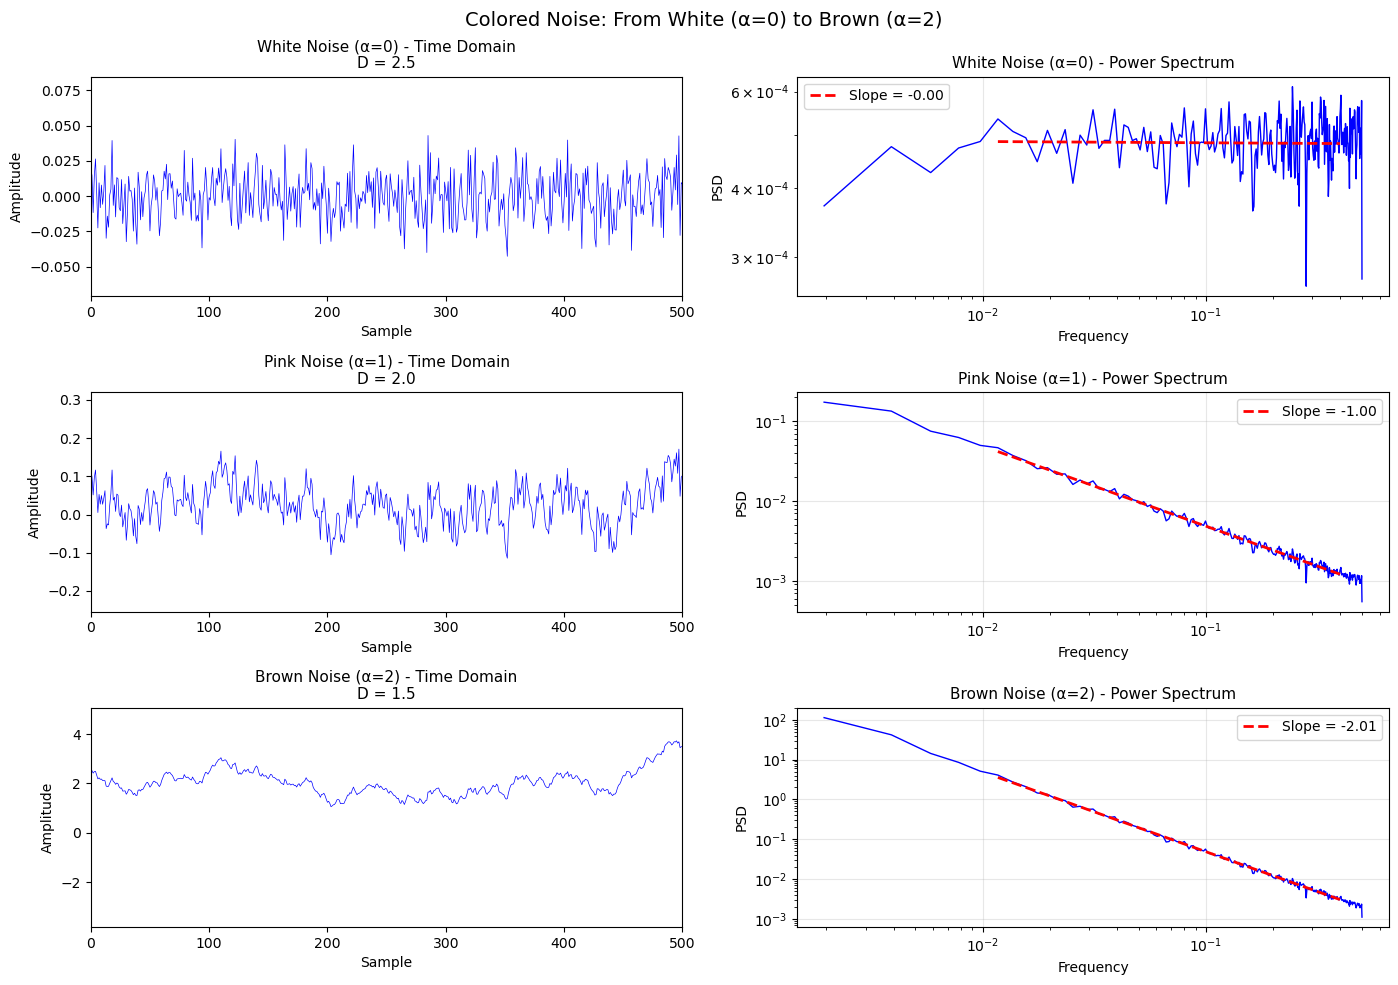

Pink noise (1/f) is ubiquitous in nature:
- Heartbeat intervals
- Ambient soundscapes
- Musical dynamics
- Neural activity (EEG)


In [2]:
def generate_colored_noise(n, alpha, seed=None):
    """
    Generate colored noise with power spectrum ~ 1/f^alpha.
    
    alpha = 0: white noise
    alpha = 1: pink noise
    alpha = 2: brown noise (Brownian)
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Generate white noise in frequency domain
    freqs = np.fft.rfftfreq(n)
    freqs[0] = 1e-10  # Avoid division by zero
    
    # Create 1/f^alpha spectrum
    spectrum = 1.0 / np.abs(freqs) ** (alpha / 2)
    spectrum[0] = 0  # Zero DC
    
    # Random phases
    phases = np.exp(2j * np.pi * np.random.rand(len(freqs)))
    
    # Generate noise
    noise_fft = spectrum * phases
    noise = np.fft.irfft(noise_fft, n)
    
    return noise - np.mean(noise)

# Compare different noise types
fig, axes = plt.subplots(3, 2, figsize=(14, 10))

noise_types = [
    (0, 'White Noise (α=0)', 'D = 2.5'),
    (1, 'Pink Noise (α=1)', 'D = 2.0'),
    (2, 'Brown Noise (α=2)', 'D = 1.5')
]

n = 4096
for i, (alpha, name, dim) in enumerate(noise_types):
    noise = generate_colored_noise(n, alpha, seed=42)
    
    # Time domain
    axes[i, 0].plot(noise, 'b-', lw=0.5)
    axes[i, 0].set_title(f'{name} - Time Domain\n{dim}', fontsize=11)
    axes[i, 0].set_xlabel('Sample')
    axes[i, 0].set_ylabel('Amplitude')
    axes[i, 0].set_xlim(0, 500)  # Zoom to see detail
    
    # Power spectrum
    freqs, psd = signal.welch(noise, nperseg=512)
    axes[i, 1].loglog(freqs[1:], psd[1:], 'b-', lw=1)
    
    # Fit line
    valid = (freqs > 0.01) & (freqs < 0.4)
    if np.sum(valid) > 2:
        slope, intercept, _, _, _ = stats.linregress(
            np.log(freqs[valid]), np.log(psd[valid])
        )
        axes[i, 1].loglog(freqs[valid], np.exp(intercept) * freqs[valid]**slope, 
                         'r--', lw=2, label=f'Slope = {slope:.2f}')
    
    axes[i, 1].set_title(f'{name} - Power Spectrum', fontsize=11)
    axes[i, 1].set_xlabel('Frequency')
    axes[i, 1].set_ylabel('PSD')
    axes[i, 1].legend()
    axes[i, 1].grid(True, alpha=0.3)

fig.suptitle('Colored Noise: From White (α=0) to Brown (α=2)', fontsize=14)
plt.tight_layout()
plt.show()

print("Pink noise (1/f) is ubiquitous in nature:")
print("- Heartbeat intervals")
print("- Ambient soundscapes")
print("- Musical dynamics")
print("- Neural activity (EEG)")

### 3.1.2 Fractional Brownian Motion

Fractional Brownian motion (fBm) is parameterized by the **Hurst exponent** $H \in (0,1)$:

- $H = 0.5$: Standard Brownian motion (random walk)
- $H > 0.5$: Persistent (trending) behavior
- $H < 0.5$: Anti-persistent (mean-reverting)

Fractal dimension: $D = 2 - H$

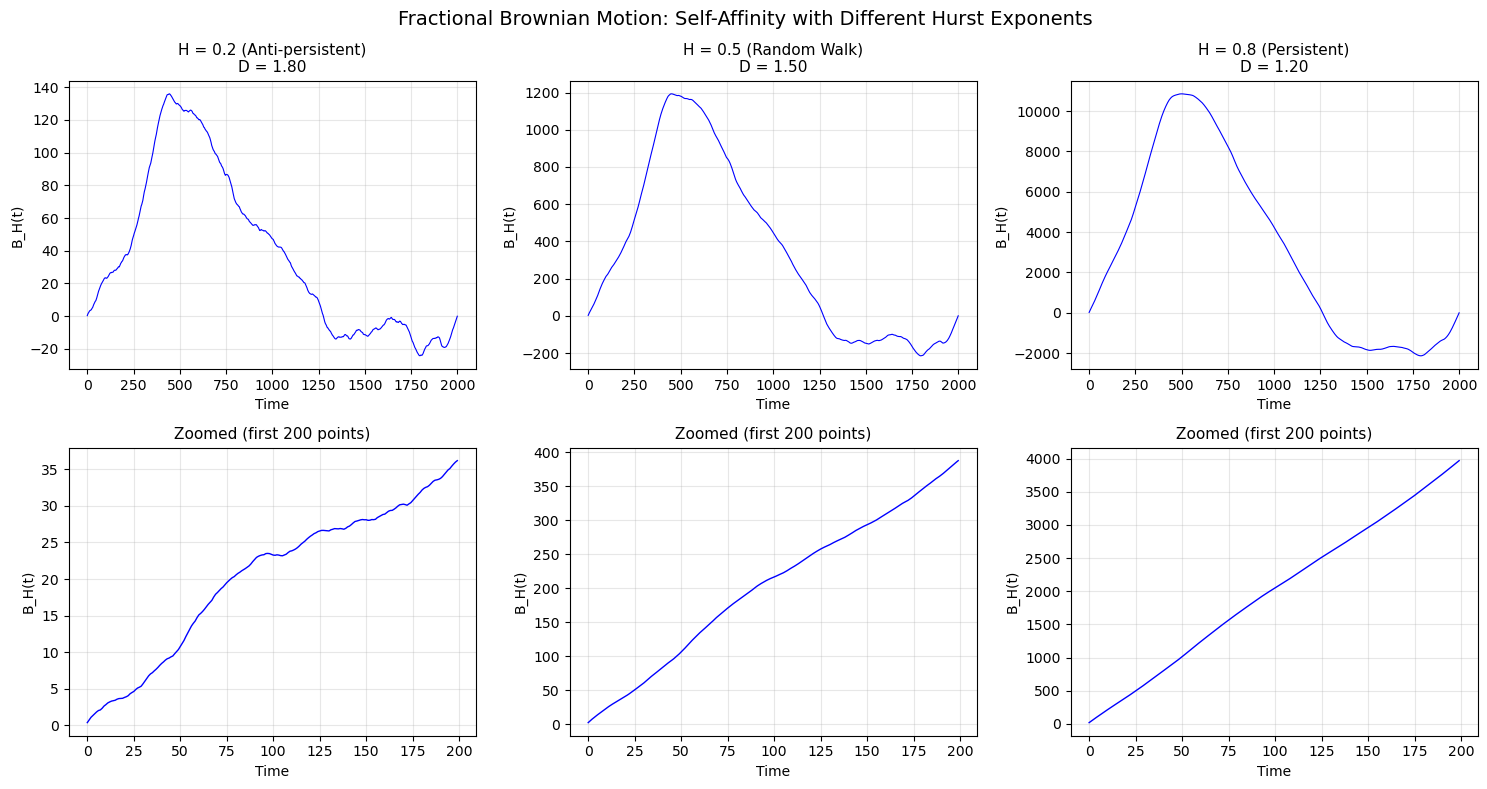


Self-Affinity Scaling: B_H(at) ≈ a^H · B_H(t)
This anisotropic scaling distinguishes self-affine from self-similar fractals.


In [3]:
def generate_fbm(n, H, seed=None):
    """Generate fractional Brownian motion via spectral synthesis."""
    if seed is not None:
        np.random.seed(seed)
    
    # Power spectrum: S(f) ~ 1/f^(2H+1)
    freqs = np.fft.rfftfreq(n)
    freqs[0] = 1e-10
    
    beta = 2 * H + 1
    spectrum = 1.0 / np.abs(freqs) ** (beta / 2)
    spectrum[0] = 0
    
    phases = np.exp(2j * np.pi * np.random.rand(len(freqs)))
    fft_signal = spectrum * phases
    fgn = np.fft.irfft(fft_signal, n)
    
    # Cumulative sum for fBm
    return np.cumsum(fgn)

# Demonstrate different H values
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

H_values = [0.2, 0.5, 0.8]
n = 2000

for i, H in enumerate(H_values):
    fbm = generate_fbm(n, H, seed=42)
    
    # Full trace
    axes[0, i].plot(fbm, 'b-', lw=0.8)
    behavior = 'Anti-persistent' if H < 0.5 else ('Persistent' if H > 0.5 else 'Random Walk')
    axes[0, i].set_title(f'H = {H} ({behavior})\nD = {2-H:.2f}', fontsize=11)
    axes[0, i].set_xlabel('Time')
    axes[0, i].set_ylabel('B_H(t)')
    axes[0, i].grid(True, alpha=0.3)
    
    # Zoom to show self-affinity
    axes[1, i].plot(fbm[:200], 'b-', lw=1)
    axes[1, i].set_title('Zoomed (first 200 points)', fontsize=11)
    axes[1, i].set_xlabel('Time')
    axes[1, i].set_ylabel('B_H(t)')
    axes[1, i].grid(True, alpha=0.3)

fig.suptitle('Fractional Brownian Motion: Self-Affinity with Different Hurst Exponents', fontsize=14)
plt.tight_layout()
plt.show()

print("\nSelf-Affinity Scaling: B_H(at) ≈ a^H · B_H(t)")
print("This anisotropic scaling distinguishes self-affine from self-similar fractals.")

### 3.1.3 Cantor Set Revisited

The Cantor set demonstrates fractal structure in 1D:
- $N = 2$ copies at scale $r = 1/3$
- $D = \log 2 / \log 3 \approx 0.631$

Despite having **measure zero**, it contains **uncountably many** points.

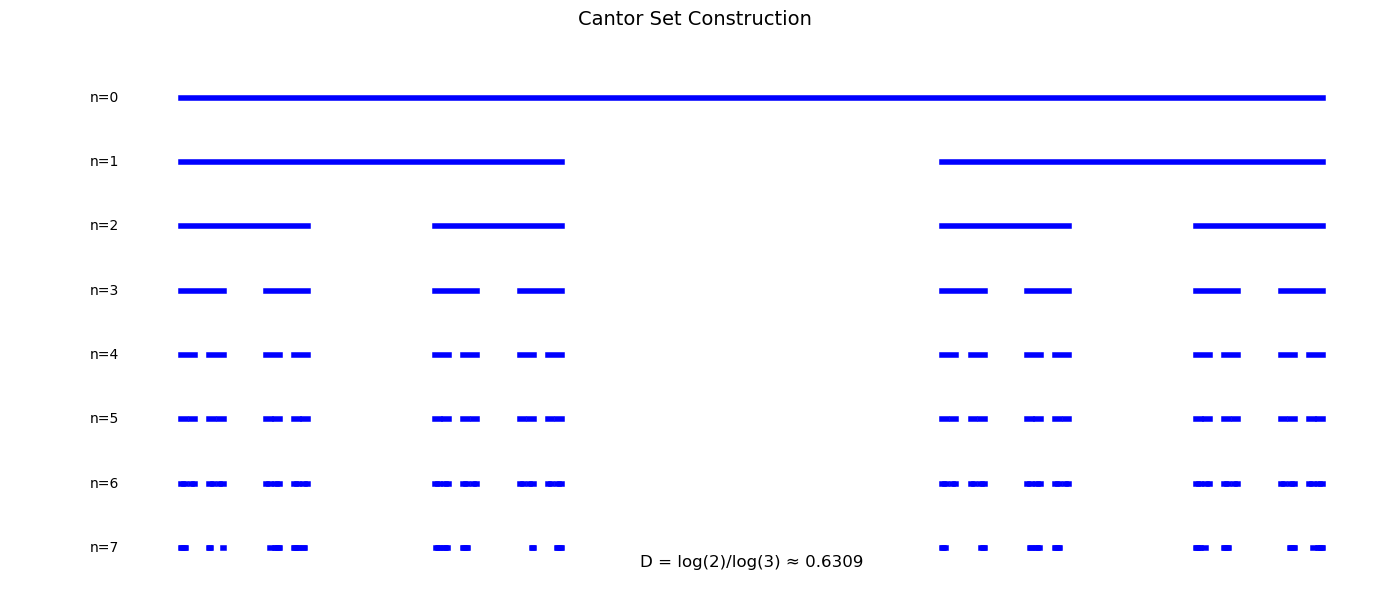


Cantor Set Properties:
  - Measure: 0 (total length removed = 1)
  - Cardinality: Uncountably infinite
  - Dimension: 0.6309


In [4]:
def cantor_intervals(depth):
    """Generate Cantor set as list of intervals."""
    intervals = [(0.0, 1.0)]
    
    for _ in range(depth):
        new_intervals = []
        for left, right in intervals:
            length = (right - left) / 3
            new_intervals.append((left, left + length))
            new_intervals.append((right - length, right))
        intervals = new_intervals
    
    return intervals

# Visualize construction stages
fig, ax = plt.subplots(figsize=(14, 6))

for depth in range(8):
    intervals = cantor_intervals(depth)
    y = 7 - depth
    for left, right in intervals:
        ax.plot([left, right], [y, y], 'b-', lw=4)
    ax.text(-0.08, y, f'n={depth}', fontsize=10, va='center')

ax.set_xlim(-0.15, 1.05)
ax.set_ylim(-0.5, 8)
ax.set_title('Cantor Set Construction', fontsize=14)
ax.set_xlabel('x')
ax.axis('off')

# Add dimension calculation
D = np.log(2) / np.log(3)
ax.text(0.5, -0.3, f'D = log(2)/log(3) ≈ {D:.4f}', fontsize=12, ha='center')

plt.tight_layout()
plt.show()

print("\nCantor Set Properties:")
print(f"  - Measure: 0 (total length removed = 1)")
print(f"  - Cardinality: Uncountably infinite")
print(f"  - Dimension: {D:.4f}")

---
## 3.2 Two-Dimensional Fractals

2D fractals encompass surfaces, planar curves, and images with fractal characteristics.

### 3.2.1 Fractional Brownian Surfaces

For 2D surfaces: $D = 3 - H$

Low H → rough surface, high D; High H → smooth surface, low D

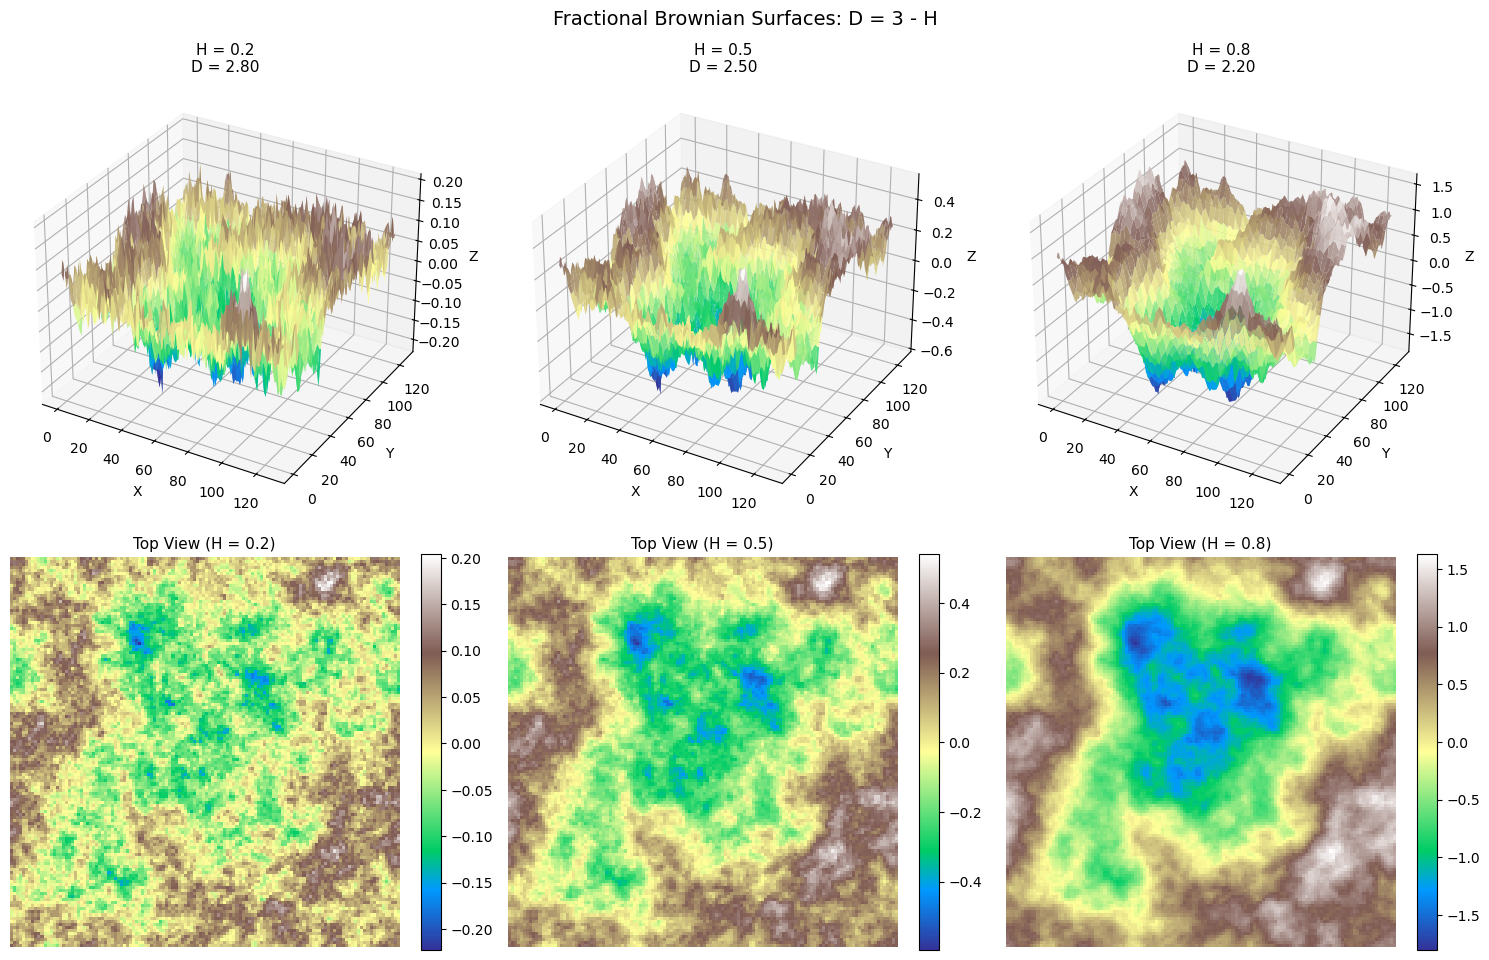

Applications:
- Terrain generation (computer graphics)
- Geological surface modeling
- Medical imaging (tissue surfaces)


In [5]:
def generate_fbs(size, H, seed=None):
    """Generate fractional Brownian surface."""
    if seed is not None:
        np.random.seed(seed)
    
    # 2D frequency grid
    fx = np.fft.fftfreq(size)
    fy = np.fft.fftfreq(size)
    FX, FY = np.meshgrid(fx, fy)
    
    # Magnitude
    F = np.sqrt(FX**2 + FY**2)
    F[0, 0] = 1e-10
    
    # Power spectrum: S(f) ~ 1/f^(2H+2) for 2D
    beta = 2 * H + 2
    spectrum = 1.0 / F ** (beta / 2)
    spectrum[0, 0] = 0
    
    # Random phases
    phases = np.exp(2j * np.pi * np.random.rand(size, size))
    
    # Generate surface
    fft_surface = spectrum * phases
    surface = np.real(np.fft.ifft2(fft_surface))
    
    return surface

# Compare surfaces with different H
fig = plt.figure(figsize=(15, 10))

H_values = [0.2, 0.5, 0.8]

for i, H in enumerate(H_values):
    surface = generate_fbs(128, H, seed=42)
    
    # 3D surface plot
    ax = fig.add_subplot(2, 3, i + 1, projection='3d')
    X, Y = np.meshgrid(range(128), range(128))
    ax.plot_surface(X, Y, surface, cmap='terrain', alpha=0.9,
                    linewidth=0, antialiased=True)
    ax.set_title(f'H = {H}\nD = {3-H:.2f}', fontsize=11)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    # 2D view
    ax2 = fig.add_subplot(2, 3, i + 4)
    im = ax2.imshow(surface, cmap='terrain')
    ax2.set_title(f'Top View (H = {H})', fontsize=11)
    ax2.axis('off')
    plt.colorbar(im, ax=ax2, fraction=0.046)

fig.suptitle('Fractional Brownian Surfaces: D = 3 - H', fontsize=14)
plt.tight_layout()
plt.show()

print("Applications:")
print("- Terrain generation (computer graphics)")
print("- Geological surface modeling")
print("- Medical imaging (tissue surfaces)")

### 3.2.2 Mandelbrot and Julia Sets

For $f_c(z) = z^2 + c$:

- **Julia Set** $J_c$: boundary between bounded and escaping orbits (fixed $c$, varying $z_0$)
- **Mandelbrot Set** $\mathcal{M}$: values of $c$ for which orbit of $z_0=0$ stays bounded

The Mandelbrot set boundary has Hausdorff dimension **exactly 2**.

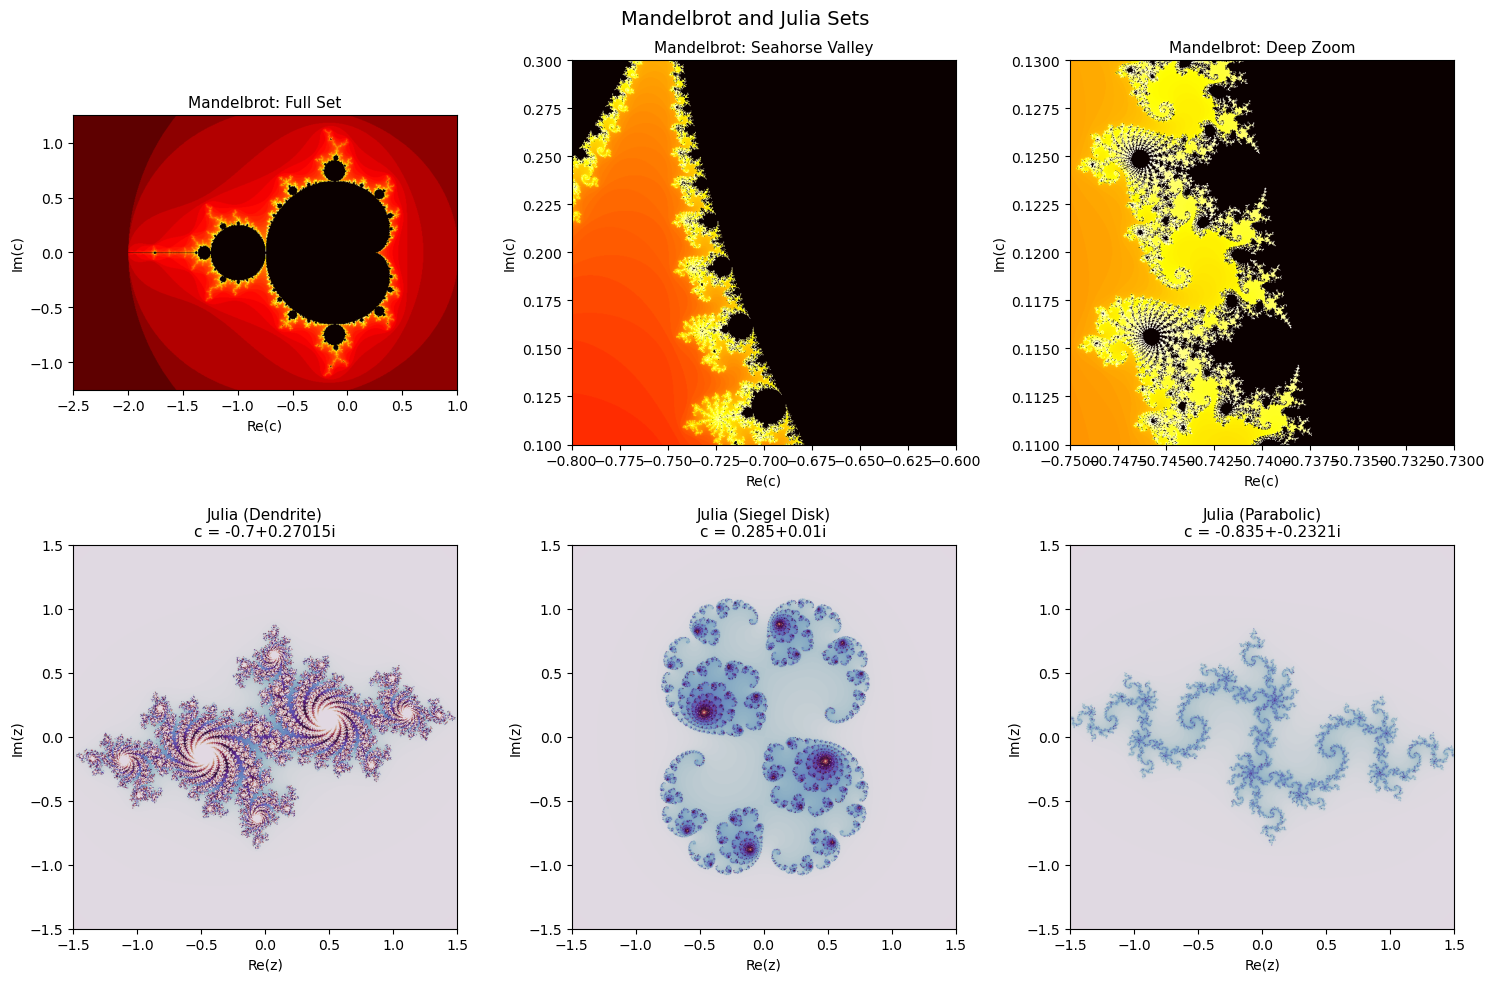

In [6]:
@jit(nopython=True, parallel=True)
def compute_mandelbrot(x_min, x_max, y_min, y_max, width, height, max_iter):
    result = np.zeros((height, width))
    for j in prange(height):
        for i in range(width):
            c_re = x_min + (x_max - x_min) * i / width
            c_im = y_min + (y_max - y_min) * j / height
            zx, zy = 0.0, 0.0
            for n in range(max_iter):
                if zx*zx + zy*zy > 4:
                    result[j, i] = n
                    break
                xtemp = zx*zx - zy*zy + c_re
                zy = 2*zx*zy + c_im
                zx = xtemp
    return result

@jit(nopython=True, parallel=True)
def compute_julia(c_re, c_im, x_min, x_max, y_min, y_max, width, height, max_iter):
    result = np.zeros((height, width))
    for j in prange(height):
        for i in range(width):
            zx = x_min + (x_max - x_min) * i / width
            zy = y_min + (y_max - y_min) * j / height
            for n in range(max_iter):
                if zx*zx + zy*zy > 4:
                    result[j, i] = n
                    break
                xtemp = zx*zx - zy*zy + c_re
                zy = 2*zx*zy + c_im
                zx = xtemp
    return result

# Mandelbrot with zoom
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Top row: Mandelbrot at different zooms
mandelbrot_regions = [
    ((-2.5, 1.0, -1.25, 1.25), "Full Set"),
    ((-0.8, -0.6, 0.1, 0.3), "Seahorse Valley"),
    ((-0.75, -0.73, 0.11, 0.13), "Deep Zoom")
]

for i, ((x_min, x_max, y_min, y_max), title) in enumerate(mandelbrot_regions):
    m = compute_mandelbrot(x_min, x_max, y_min, y_max, 600, 600, 256)
    axes[0, i].imshow(np.log(m + 1), cmap='hot', extent=[x_min, x_max, y_min, y_max])
    axes[0, i].set_title(f'Mandelbrot: {title}', fontsize=11)
    axes[0, i].set_xlabel('Re(c)')
    axes[0, i].set_ylabel('Im(c)')

# Bottom row: Julia sets
julia_params = [
    ((-0.7, 0.27015), "Dendrite"),
    ((0.285, 0.01), "Siegel Disk"),
    ((-0.835, -0.2321), "Parabolic")
]

for i, ((c_re, c_im), name) in enumerate(julia_params):
    j = compute_julia(c_re, c_im, -1.5, 1.5, -1.5, 1.5, 600, 600, 256)
    axes[1, i].imshow(j, cmap='twilight', extent=[-1.5, 1.5, -1.5, 1.5])
    axes[1, i].set_title(f'Julia ({name})\nc = {c_re}+{c_im}i', fontsize=11)
    axes[1, i].set_xlabel('Re(z)')
    axes[1, i].set_ylabel('Im(z)')

fig.suptitle('Mandelbrot and Julia Sets', fontsize=14)
plt.tight_layout()
plt.show()

### 3.2.3 Koch Curves and Sierpinski Structures

| Fractal | $N$ | $r$ | $D$ |
|---------|-----|-----|-----|
| Koch Curve | 4 | 1/3 | 1.262 |
| Sierpinski Triangle | 3 | 1/2 | 1.585 |
| Sierpinski Carpet | 8 | 1/3 | 1.893 |

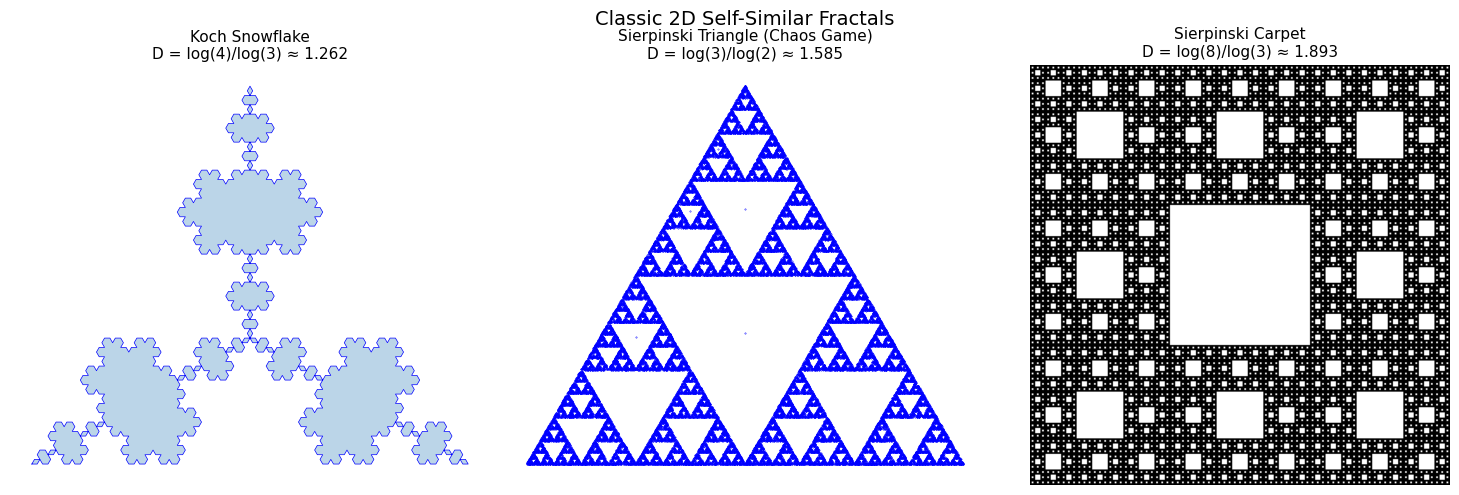

In [7]:
def koch_curve(p1, p2, depth):
    """Generate Koch curve points."""
    if depth == 0:
        return [p1, p2]
    dx, dy = p2[0] - p1[0], p2[1] - p1[1]
    a, e = p1, p2
    b = (p1[0] + dx/3, p1[1] + dy/3)
    d = (p1[0] + 2*dx/3, p1[1] + 2*dy/3)
    c = (b[0] + dx/6 - dy*np.sqrt(3)/6, b[1] + dy/6 + dx*np.sqrt(3)/6)
    
    points = []
    for seg in [(a, b), (b, c), (c, d), (d, e)]:
        pts = koch_curve(seg[0], seg[1], depth - 1)
        points.extend(pts[:-1])
    points.append(e)
    return points

def sierpinski_carpet_image(size, depth):
    """Generate Sierpinski carpet."""
    carpet = np.ones((size, size), dtype=bool)
    for d in range(1, depth + 1):
        step = size // (3 ** d)
        for y in range(0, size, step * 3):
            for x in range(0, size, step * 3):
                carpet[y + step:y + 2*step, x + step:x + 2*step] = False
    return carpet

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Koch snowflake
h = np.sqrt(3) / 2
verts = [(0, 0), (1, 0), (0.5, h)]
all_pts = []
for i in range(3):
    pts = koch_curve(verts[i], verts[(i+1)%3], 4)
    all_pts.extend(pts[:-1])
all_pts.append(all_pts[0])
xs, ys = zip(*all_pts)
axes[0].plot(xs, ys, 'b-', lw=0.5)
axes[0].fill(xs, ys, alpha=0.3)
axes[0].set_title(f'Koch Snowflake\nD = log(4)/log(3) ≈ 1.262', fontsize=11)
axes[0].set_aspect('equal')
axes[0].axis('off')

# Sierpinski triangle (chaos game)
np.random.seed(42)
verts = np.array([[0, 0], [1, 0], [0.5, h]])
point = np.array([0.5, 0.3])
points = [point.copy()]
for _ in range(50000):
    v = verts[np.random.randint(3)]
    point = (point + v) / 2
    points.append(point.copy())
points = np.array(points)
axes[1].scatter(points[:, 0], points[:, 1], s=0.1, c='blue')
axes[1].set_title(f'Sierpinski Triangle (Chaos Game)\nD = log(3)/log(2) ≈ 1.585', fontsize=11)
axes[1].set_aspect('equal')
axes[1].axis('off')

# Sierpinski carpet
carpet = sierpinski_carpet_image(243, 5)
axes[2].imshow(carpet, cmap='binary')
axes[2].set_title(f'Sierpinski Carpet\nD = log(8)/log(3) ≈ 1.893', fontsize=11)
axes[2].axis('off')

fig.suptitle('Classic 2D Self-Similar Fractals', fontsize=14)
plt.tight_layout()
plt.show()

---
## 3.3 Three-Dimensional Fractals

3D fractals model porous structures, branching networks, and aggregation phenomena.

### 3.3.1 Menger Sponge

The 3D analog of Sierpinski carpet:
- Divide cube into $3 \times 3 \times 3 = 27$ subcubes
- Remove center and 6 face centers (7 total), leaving 20
- $D = \log 20 / \log 3 \approx 2.727$

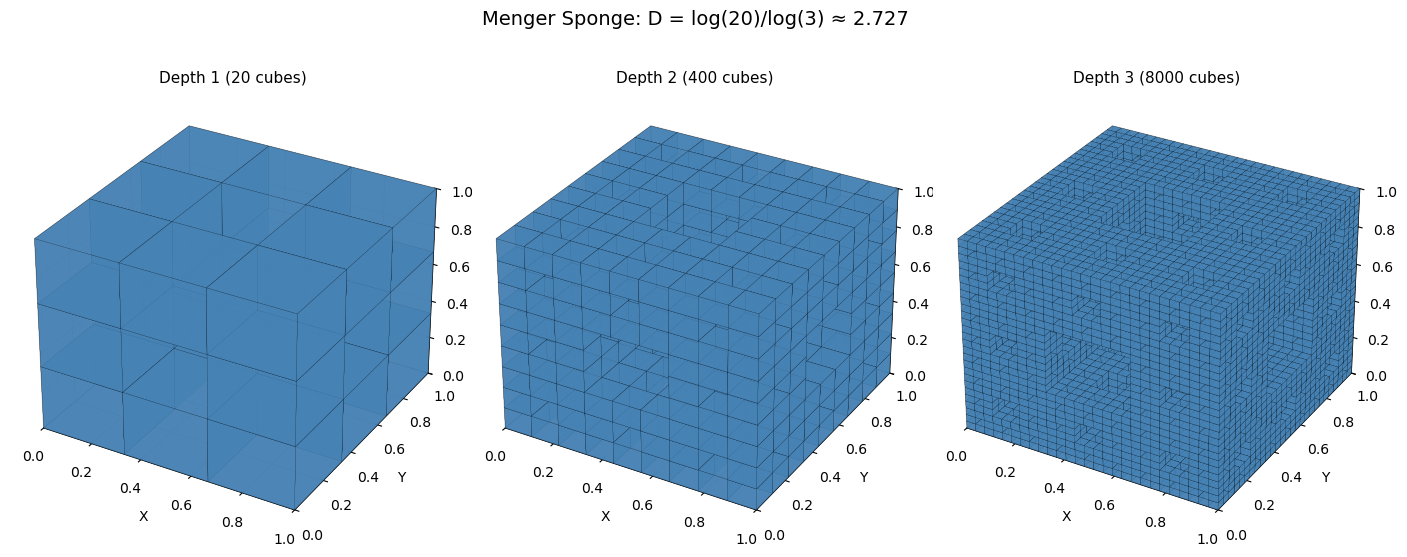


Menger Sponge Properties:
  - Volume → 0 (as depth → ∞)
  - Surface area → ∞
  - Cross-sections are Sierpinski carpets


In [8]:
def menger_cubes(x, y, z, size, depth):
    """Generate Menger sponge cube positions."""
    if depth == 0:
        return [(x, y, z, size)]
    
    new_size = size / 3
    cubes = []
    
    for dx in range(3):
        for dy in range(3):
            for dz in range(3):
                # Skip center and face centers
                count = (dx == 1) + (dy == 1) + (dz == 1)
                if count >= 2:  # Center or face center
                    continue
                
                new_x = x + dx * new_size
                new_y = y + dy * new_size
                new_z = z + dz * new_size
                
                cubes.extend(menger_cubes(new_x, new_y, new_z, new_size, depth - 1))
    
    return cubes

def draw_cube(ax, x, y, z, size, color='blue', alpha=0.7):
    """Draw a cube."""
    # Vertices
    v = np.array([[x, y, z], [x+size, y, z], [x+size, y+size, z], [x, y+size, z],
                  [x, y, z+size], [x+size, y, z+size], [x+size, y+size, z+size], [x, y+size, z+size]])
    
    # Faces
    faces = [[v[0], v[1], v[2], v[3]], [v[4], v[5], v[6], v[7]],  # bottom, top
             [v[0], v[1], v[5], v[4]], [v[2], v[3], v[7], v[6]],  # front, back
             [v[1], v[2], v[6], v[5]], [v[0], v[3], v[7], v[4]]]  # right, left
    
    ax.add_collection3d(Poly3DCollection(faces, facecolors=color, 
                                          linewidths=0.1, edgecolors='black', alpha=alpha))

# Generate and visualize Menger sponge
fig = plt.figure(figsize=(14, 6))

for i, depth in enumerate([1, 2, 3]):
    ax = fig.add_subplot(1, 3, i + 1, projection='3d')
    
    cubes = menger_cubes(0, 0, 0, 1, depth)
    
    for x, y, z, size in cubes:
        draw_cube(ax, x, y, z, size, color='steelblue', alpha=0.8)
    
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, 1)
    ax.set_title(f'Depth {depth} ({len(cubes)} cubes)', fontsize=11)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

D_menger = np.log(20) / np.log(3)
fig.suptitle(f'Menger Sponge: D = log(20)/log(3) ≈ {D_menger:.3f}', fontsize=14)
plt.tight_layout()
plt.show()

print(f"\nMenger Sponge Properties:")
print(f"  - Volume → 0 (as depth → ∞)")
print(f"  - Surface area → ∞")
print(f"  - Cross-sections are Sierpinski carpets")

### 3.3.2 Diffusion-Limited Aggregation (DLA)

DLA produces branching, dendritic structures:
1. Place seed particle at origin
2. Release random walker from far away
3. Walker diffuses until it contacts cluster
4. Repeat

3D DLA has $D \approx 2.5$

Generating DLA cluster (this may take a moment)...


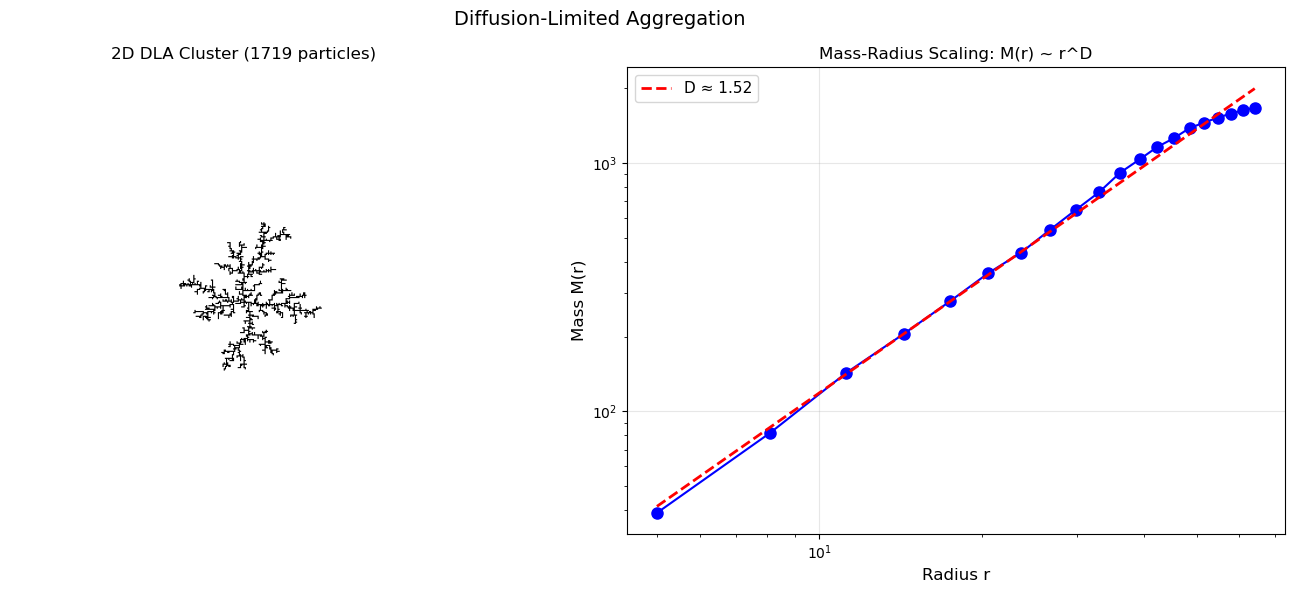


2D DLA fractal dimension: D ≈ 1.519
Theoretical value: D ≈ 1.71

DLA appears in: electrodeposition, bacterial colonies, coral growth


In [9]:
def dla_2d(n_particles, grid_size=500, seed=None):
    """
    Simple 2D DLA simulation.
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Grid to track occupied sites
    grid = np.zeros((grid_size, grid_size), dtype=bool)
    center = grid_size // 2
    
    # Seed particle
    grid[center, center] = True
    particles = [(center, center)]
    
    # Maximum cluster radius
    max_radius = 1
    
    for _ in range(n_particles - 1):
        # Launch from random position on circle
        launch_radius = max_radius + 10
        theta = np.random.rand() * 2 * np.pi
        x = int(center + launch_radius * np.cos(theta))
        y = int(center + launch_radius * np.sin(theta))
        
        # Random walk
        kill_radius = 2 * launch_radius
        stuck = False
        
        while not stuck:
            # Check if too far
            if np.sqrt((x - center)**2 + (y - center)**2) > kill_radius:
                break
            
            # Random step
            direction = np.random.randint(4)
            if direction == 0: x += 1
            elif direction == 1: x -= 1
            elif direction == 2: y += 1
            else: y -= 1
            
            # Boundary check
            if x < 1 or x >= grid_size - 1 or y < 1 or y >= grid_size - 1:
                break
            
            # Check for neighbors
            if (grid[x-1, y] or grid[x+1, y] or grid[x, y-1] or grid[x, y+1]):
                grid[x, y] = True
                particles.append((x, y))
                r = np.sqrt((x - center)**2 + (y - center)**2)
                max_radius = max(max_radius, r)
                stuck = True
    
    return grid, np.array(particles)

# Generate DLA cluster
print("Generating DLA cluster (this may take a moment)...")
grid, particles = dla_2d(3000, grid_size=400, seed=42)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Show cluster
axes[0].imshow(grid, cmap='binary', origin='lower')
axes[0].set_title(f'2D DLA Cluster ({len(particles)} particles)', fontsize=12)
axes[0].axis('off')

# Mass vs radius analysis
center = 200
radii = np.sqrt((particles[:, 0] - center)**2 + (particles[:, 1] - center)**2)
r_bins = np.linspace(5, radii.max() * 0.9, 20)
mass_r = [np.sum(radii <= r) for r in r_bins]

# Log-log plot
log_r = np.log(r_bins)
log_m = np.log(mass_r)
valid = np.isfinite(log_m) & (np.array(mass_r) > 0)

slope, intercept, _, _, _ = stats.linregress(log_r[valid], log_m[valid])

axes[1].loglog(r_bins, mass_r, 'bo-', markersize=8)
axes[1].loglog(r_bins, np.exp(intercept) * r_bins**slope, 'r--', lw=2,
               label=f'D ≈ {slope:.2f}')
axes[1].set_xlabel('Radius r', fontsize=12)
axes[1].set_ylabel('Mass M(r)', fontsize=12)
axes[1].set_title('Mass-Radius Scaling: M(r) ~ r^D', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

fig.suptitle('Diffusion-Limited Aggregation', fontsize=14)
plt.tight_layout()
plt.show()

print(f"\n2D DLA fractal dimension: D ≈ {slope:.3f}")
print(f"Theoretical value: D ≈ 1.71")
print(f"\nDLA appears in: electrodeposition, bacterial colonies, coral growth")

---
## 3.4 Four-Dimensional Fractals (Time-Evolving)

4D fractals incorporate time as the fourth dimension, capturing growth dynamics.

### 3.4.1 Growth Dynamics

For DLA growth: $R(t) \sim t^{1/D}$

The growth exponent relates to the spatial fractal dimension.

Tracking DLA growth evolution...


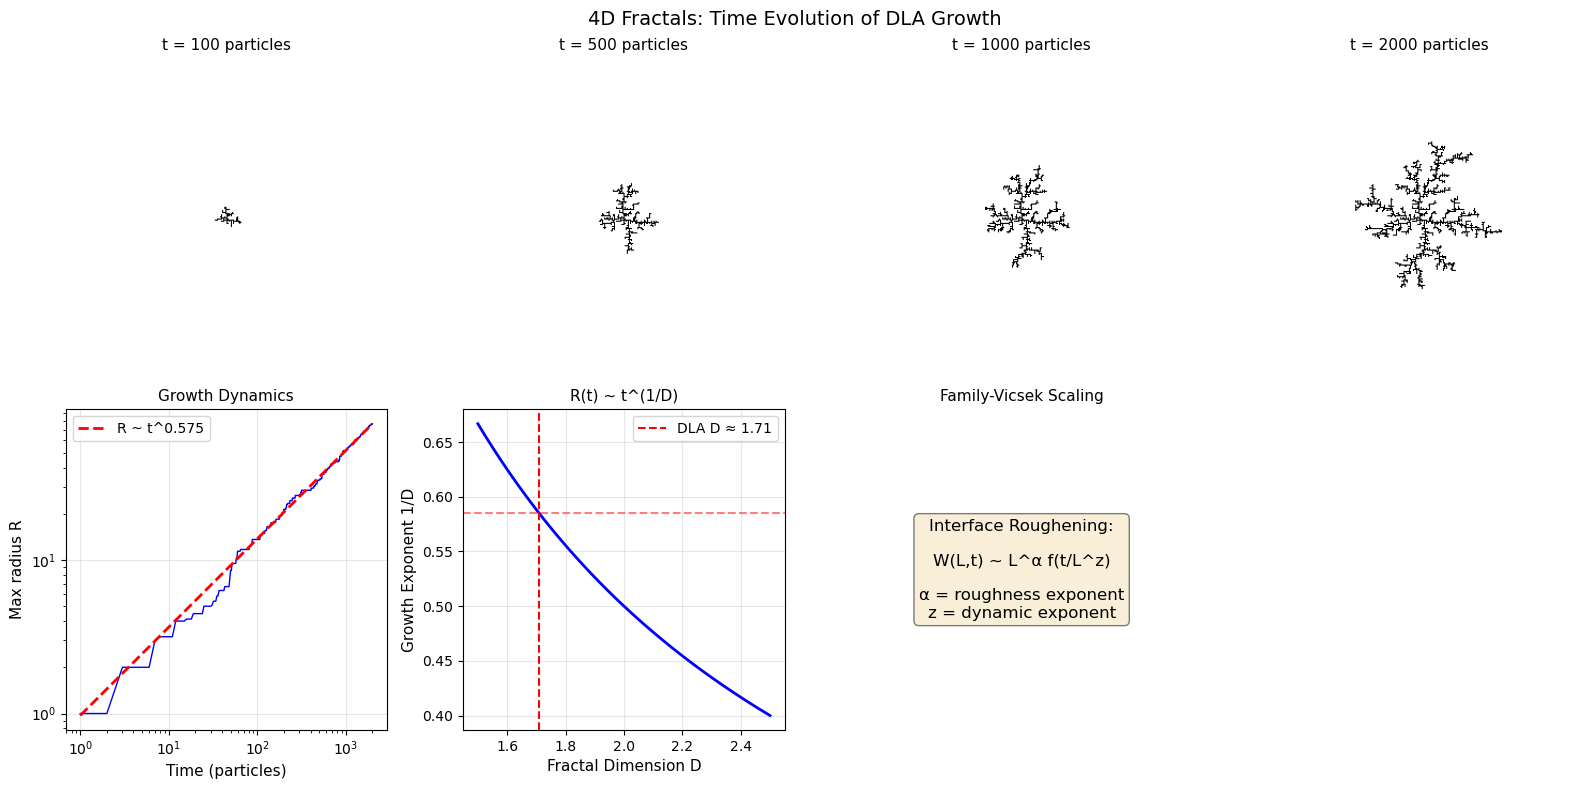


Measured growth exponent: 0.575
Expected for D ≈ 1.71: 1/D ≈ 0.585


In [10]:
def dla_growth_evolution(n_particles_list, grid_size=300, seed=42):
    """Track DLA cluster evolution over time."""
    np.random.seed(seed)
    
    grid = np.zeros((grid_size, grid_size), dtype=bool)
    center = grid_size // 2
    grid[center, center] = True
    
    particles = [(center, center)]
    max_radius = 1
    radii_history = [0]
    
    snapshots = {}
    
    for target_n in n_particles_list:
        while len(particles) < target_n:
            launch_radius = max_radius + 10
            theta = np.random.rand() * 2 * np.pi
            x = int(center + launch_radius * np.cos(theta))
            y = int(center + launch_radius * np.sin(theta))
            
            kill_radius = 2 * launch_radius
            stuck = False
            
            while not stuck:
                if np.sqrt((x - center)**2 + (y - center)**2) > kill_radius:
                    break
                
                direction = np.random.randint(4)
                if direction == 0: x += 1
                elif direction == 1: x -= 1
                elif direction == 2: y += 1
                else: y -= 1
                
                if x < 1 or x >= grid_size - 1 or y < 1 or y >= grid_size - 1:
                    break
                
                if (grid[x-1, y] or grid[x+1, y] or grid[x, y-1] or grid[x, y+1]):
                    grid[x, y] = True
                    particles.append((x, y))
                    r = np.sqrt((x - center)**2 + (y - center)**2)
                    max_radius = max(max_radius, r)
                    radii_history.append(max_radius)
                    stuck = True
        
        snapshots[target_n] = grid.copy()
    
    return snapshots, radii_history

# Track evolution
print("Tracking DLA growth evolution...")
n_list = [100, 500, 1000, 2000]
snapshots, radii = dla_growth_evolution(n_list)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Top row: snapshots
for i, n in enumerate(n_list):
    axes[0, i].imshow(snapshots[n], cmap='binary', origin='lower')
    axes[0, i].set_title(f't = {n} particles', fontsize=11)
    axes[0, i].axis('off')

# Bottom left: R vs t
t = np.arange(1, len(radii))
r = np.array(radii[1:])

axes[1, 0].loglog(t, r, 'b-', lw=1)
# Fit
valid = (t > 50) & (t < len(t) - 10)
slope, intercept, _, _, _ = stats.linregress(np.log(t[valid]), np.log(r[valid]))
axes[1, 0].loglog(t, np.exp(intercept) * t**slope, 'r--', lw=2,
                  label=f'R ~ t^{slope:.3f}')
axes[1, 0].set_xlabel('Time (particles)', fontsize=11)
axes[1, 0].set_ylabel('Max radius R', fontsize=11)
axes[1, 0].set_title('Growth Dynamics', fontsize=11)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Bottom middle: theoretical relationship
D_values = np.linspace(1.5, 2.5, 50)
growth_exp = 1 / D_values
axes[1, 1].plot(D_values, growth_exp, 'b-', lw=2)
axes[1, 1].axvline(x=1.71, color='r', linestyle='--', label='DLA D ≈ 1.71')
axes[1, 1].axhline(y=1/1.71, color='r', linestyle='--', alpha=0.5)
axes[1, 1].set_xlabel('Fractal Dimension D', fontsize=11)
axes[1, 1].set_ylabel('Growth Exponent 1/D', fontsize=11)
axes[1, 1].set_title('R(t) ~ t^(1/D)', fontsize=11)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Bottom right: family-vicsek scaling concept
axes[1, 2].text(0.5, 0.5, 'Interface Roughening:\n\nW(L,t) ~ L^α f(t/L^z)\n\nα = roughness exponent\nz = dynamic exponent',
                ha='center', va='center', fontsize=12,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                transform=axes[1, 2].transAxes)
axes[1, 2].set_title('Family-Vicsek Scaling', fontsize=11)
axes[1, 2].axis('off')

# Hide last subplot
axes[1, 3].axis('off')

fig.suptitle('4D Fractals: Time Evolution of DLA Growth', fontsize=14)
plt.tight_layout()
plt.show()

print(f"\nMeasured growth exponent: {slope:.3f}")
print(f"Expected for D ≈ 1.71: 1/D ≈ {1/1.71:.3f}")

---
## Summary: Fractal Dimensions Across Scales

| Dimension | Examples | Typical D | Applications |
|-----------|----------|-----------|-------------|
| 1D | Pink noise, fBm, Cantor | 0.6-2.0 | Signal processing, time series |
| 2D | fBs, Mandelbrot, Koch | 1.2-2.5 | Terrain, image analysis |
| 3D | Menger, DLA, vascular | 2.5-2.9 | Porous media, biology |
| 4D | Growth dynamics | Variable | Physics, biology |

In [11]:
# Summary table of fractal dimensions
print("Fractal Dimension Reference Table")
print("=" * 65)
print(f"{'Fractal':<25} {'Dim':<5} {'D Formula':<20} {'D Value':<10}")
print("-" * 65)

fractals = [
    ("Cantor Set", "1D", "log(2)/log(3)", np.log(2)/np.log(3)),
    ("fBm trace (H=0.5)", "1D", "2 - H", 1.5),
    ("Koch Curve", "2D", "log(4)/log(3)", np.log(4)/np.log(3)),
    ("Sierpinski Triangle", "2D", "log(3)/log(2)", np.log(3)/np.log(2)),
    ("Sierpinski Carpet", "2D", "log(8)/log(3)", np.log(8)/np.log(3)),
    ("Mandelbrot Boundary", "2D", "-", 2.0),
    ("2D DLA", "2D", "-", 1.71),
    ("fBs (H=0.5)", "3D", "3 - H", 2.5),
    ("Menger Sponge", "3D", "log(20)/log(3)", np.log(20)/np.log(3)),
    ("3D DLA", "3D", "-", 2.5),
]

for name, dim, formula, value in fractals:
    print(f"{name:<25} {dim:<5} {formula:<20} {value:<10.4f}")

print("=" * 65)

Fractal Dimension Reference Table
Fractal                   Dim   D Formula            D Value   
-----------------------------------------------------------------
Cantor Set                1D    log(2)/log(3)        0.6309    
fBm trace (H=0.5)         1D    2 - H                1.5000    
Koch Curve                2D    log(4)/log(3)        1.2619    
Sierpinski Triangle       2D    log(3)/log(2)        1.5850    
Sierpinski Carpet         2D    log(8)/log(3)        1.8928    
Mandelbrot Boundary       2D    -                    2.0000    
2D DLA                    2D    -                    1.7100    
fBs (H=0.5)               3D    3 - H                2.5000    
Menger Sponge             3D    log(20)/log(3)       2.7268    
3D DLA                    3D    -                    2.5000    
